# Example 11.0.1+11.1.1 Construction Costs of Nuclear Power Plants, AIC, adjR2, Cp

Author: Marcel Steiner-Curtis \
Date: 07.03.2021 sml: Python-Jupyter Notebook

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model as sm

In [2]:
#   Automated Stepwise Backward and Forward Selection
#   -------------------------------------------------
#   This script is about an automated stepwise backward and 
#   forward feature selection. You can easily apply on Dataframes.
#   Functions returns not only the final features but also elimination 
#   iterations, so you can track what exactly happend at the iterations.
#   You can apply it on both Linear and Logistic problems. Eliminations 
#   can be apply with Akaike information criterion (AIC), 
#   Bayesian information criterion (BIC), R-squared (Only works with linear), 
#   Adjusted R-squared (Only works with linear). 
#   Also you don't have to worry about varchar variables, 
#   code will handle it for you.
#   Required Libraries: pandas, numpy, statmodels
#   Source: https://github.com/talhahascelik/python_stepwiseSelection
#   Author: Sinan Talha Hascelik
#   Date: 22.04.2019
def forwardSelection(X, y, model_type="linear", 
                     elimination_criteria="aic", 
                     varchar_process="dummy_dropfirst", 
                     sl=0.05):
    """
    Forward Selection is a function, based on regression models, 
    that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
                           'aic' refers Akaike information criterion\n
                           'bic' refers Bayesian information criterion\n
                           'r2' refers R-squared (Only works on linear model type)\n
                           'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
                      'drop' drops varchar features\n
                      'dummy' creates dummies for all levels of all varchars\n
                      'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    sl : Significance Level (default: 0.05)\n
    
    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    
    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    
    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression
    """
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __forwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)
    
def backwardSelection(X, y, model_type="linear", 
                      elimination_criteria="aic", 
                      varchar_process="dummy_dropfirst", 
                      sl=0.05):
    """
    Backward Selection is a function, based on regression models, 
    that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
                           'aic' refers Akaike information criterion\n
                           'bic' refers Bayesian information criterion\n
                           'r2' refers R-squared (Only works on linear model type)\n
                           'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
                      'drop' drops varchar features\n
                      'dummy' creates dummies for all levels of all varchars\n
                      'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    sl : Significance Level (default: 0.05)\n
    
    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    
    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    
    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression    
    """
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __backwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes
    if varchar_process == "drop":   
        X = X.drop(columns = dtypes[dtypes == object].index.tolist())
        print("Character Variables (Dropped):", dtypes[dtypes == object].index.tolist())
    elif varchar_process == "dummy":
        X = pd.get_dummies(X,drop_first=False)
        print("Character Variables (Dummies Generated):", dtypes[dtypes == object].index.tolist())
    elif varchar_process == "dummy_dropfirst":
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == object].index.tolist())
    else: 
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == object].index.tolist())
    
    X["intercept"] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]
    
    return X

def __forwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):

    iterations_log = ""
    cols = X.columns.tolist()
    
    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    
    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")
    
    model = regressor(y, X[selected_cols])
    
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals = pd.concat([pvals, pd.DataFrame([[j, model.pvalues[j]]], columns = ["Cols","Pval"])])
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<=sl]
        if pvals.shape[0] > 0:
            
            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")    
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"
                    
        
            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break        
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break           
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])            
                
        else:
            print("Break : Significance Level")
            break
        
    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)

    return selected_cols, iterations_log

def __backwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):
    
    iterations_log = ""
    last_eleminated = ""    
    cols = X.columns.tolist()

    def regressor(y,X, model_type=model_type):
        if model_type =="linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    for i in range(X.shape[1]):
        if i != 0 :          
            if elimination_criteria == "aic":
                criteria = model.aic
                new_model = regressor(y,X)
                new_criteria = new_model.aic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "bic":
                criteria = model.bic
                new_model = regressor(y,X)
                new_criteria = new_model.bic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "adjr2" and model_type =="linear":
                criteria = model.rsquared_adj
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared_adj
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "r2" and model_type =="linear":
                criteria = model.rsquared
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break   
            else: 
                new_model = regressor(y,X)
            model = new_model
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        else:
            model = regressor(y,X)
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        maxPval = max(model.pvalues)
        cols = X.columns.tolist()
        if maxPval > sl:
            for j in cols:
                if (model.pvalues[j] == maxPval):
                    print("Eliminated :" ,j)
                    iterations_log += str("\n\nEliminated : "+j+ "\n\n")
                    
                    del X[j]
                    last_eleminated = j
        else:
            break
    print(str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic))
    print("Final Variables:", cols)
    iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
    return cols, iterations_log

In [3]:
#   Function to reproduce the 4 base plots of an OLS model in R
#   -----------------------------------------------------------
#   Source: https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
#   Author: Robert Alvarez
#   Date: 04.06.2018
def graph(formula, x_range, label=None):
    """
    Helper function for plotting Cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.
    ---
    Inputs:
    X: A numpy array or pandas dataframe of the features to use in building the linear regression model
    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model
    
    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                          generated from X, y
    """
    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()
    
    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    #----------------------
    #   Tukey-Anscombe plot
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x=model_fitted_y, 
                                      y=dataframe.columns[-1], 
                                      data=dataframe, 
                                      lowess=True, 
                                      color='blue', 
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals');
    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i, xy=(model_fitted_y[i], model_residuals[i]));
    #----------------------
    #   Scale-location plot
    plot_lm_2 = plt.figure()
    plt.scatter(x=model_fitted_y, y=model_norm_residuals_abs_sqrt, color='blue');
    sns.regplot(x=model_fitted_y, y=model_norm_residuals_abs_sqrt, 
                scatter=False,
                ci=False, 
                lowess=True, 
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_2.axes[0].set_title('Scale-Location')
    plot_lm_2.axes[0].set_xlabel('Fitted values')
    plot_lm_2.axes[0].set_ylabel('$\sqrt{|Standardized~~Residuals|}$');
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_2.axes[0].annotate(i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i]));
    #-----------
    #   q-q plot
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_3 = QQ.qqplot(line='45', markerfacecolor='b', markeredgecolor='b')
    plot_lm_3.axes[0].set_title('Normal Q-Q')
    plot_lm_3.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_3.axes[0].set_ylabel('Standardized Residuals');
    # annotations
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_3.axes[0].annotate(i, xy=(np.flip(QQ.theoretical_quantiles, 0)[r], model_norm_residuals[i]));
    #------------------------
    #   Residuals vs Leverage
    plot_lm_4 = plt.figure();
    plt.scatter(x=model_leverage, y=model_norm_residuals, color='blue');
    sns.regplot(x=model_leverage, 
                y=model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i, xy=(model_leverage[i], model_norm_residuals[i]));
    
    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), np.linspace(0.001, max(model_leverage), 50), 'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),  np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm_4.legend(loc='upper right');
    

## Example 11.1.1 Construction Costs of Nuclear Power Plants (NPP)

read data

In [4]:
os.chdir('../04 Datasets')
data = pd.read_csv('NPP.dat', delimiter='\t')
data.head()
data.columns.values

array(['C', 'D', 'T1', 'T2', 'S', 'PR', 'NE', 'CT', 'BW', 'N', 'PT'],
      dtype=object)

define new transformed variables and delete the original variables afterwards

In [5]:
data['Clog']  = np.log10(data.C)
data['Slog']  = np.log10(data.S)
data['Nsqrt'] =  np.sqrt(data.N)
data = data.drop(columns=['C', 'S', 'N'])
data.columns.values

array(['D', 'T1', 'T2', 'PR', 'NE', 'CT', 'BW', 'PT', 'Clog', 'Slog',
       'Nsqrt'], dtype=object)

order columns as in original data set

In [6]:
data = data.reindex(['Clog', 'D', 'T1', 'T2', 'Slog', 'PR', 'NE', 'CT', 'BW', 'Nsqrt', 'PT'], axis=1)
data.columns.values

array(['Clog', 'D', 'T1', 'T2', 'Slog', 'PR', 'NE', 'CT', 'BW', 'Nsqrt',
       'PT'], dtype=object)

Dependent and Independent Variables

In [7]:
X = data.drop(columns='Clog')
y = data.Clog

pairs plot

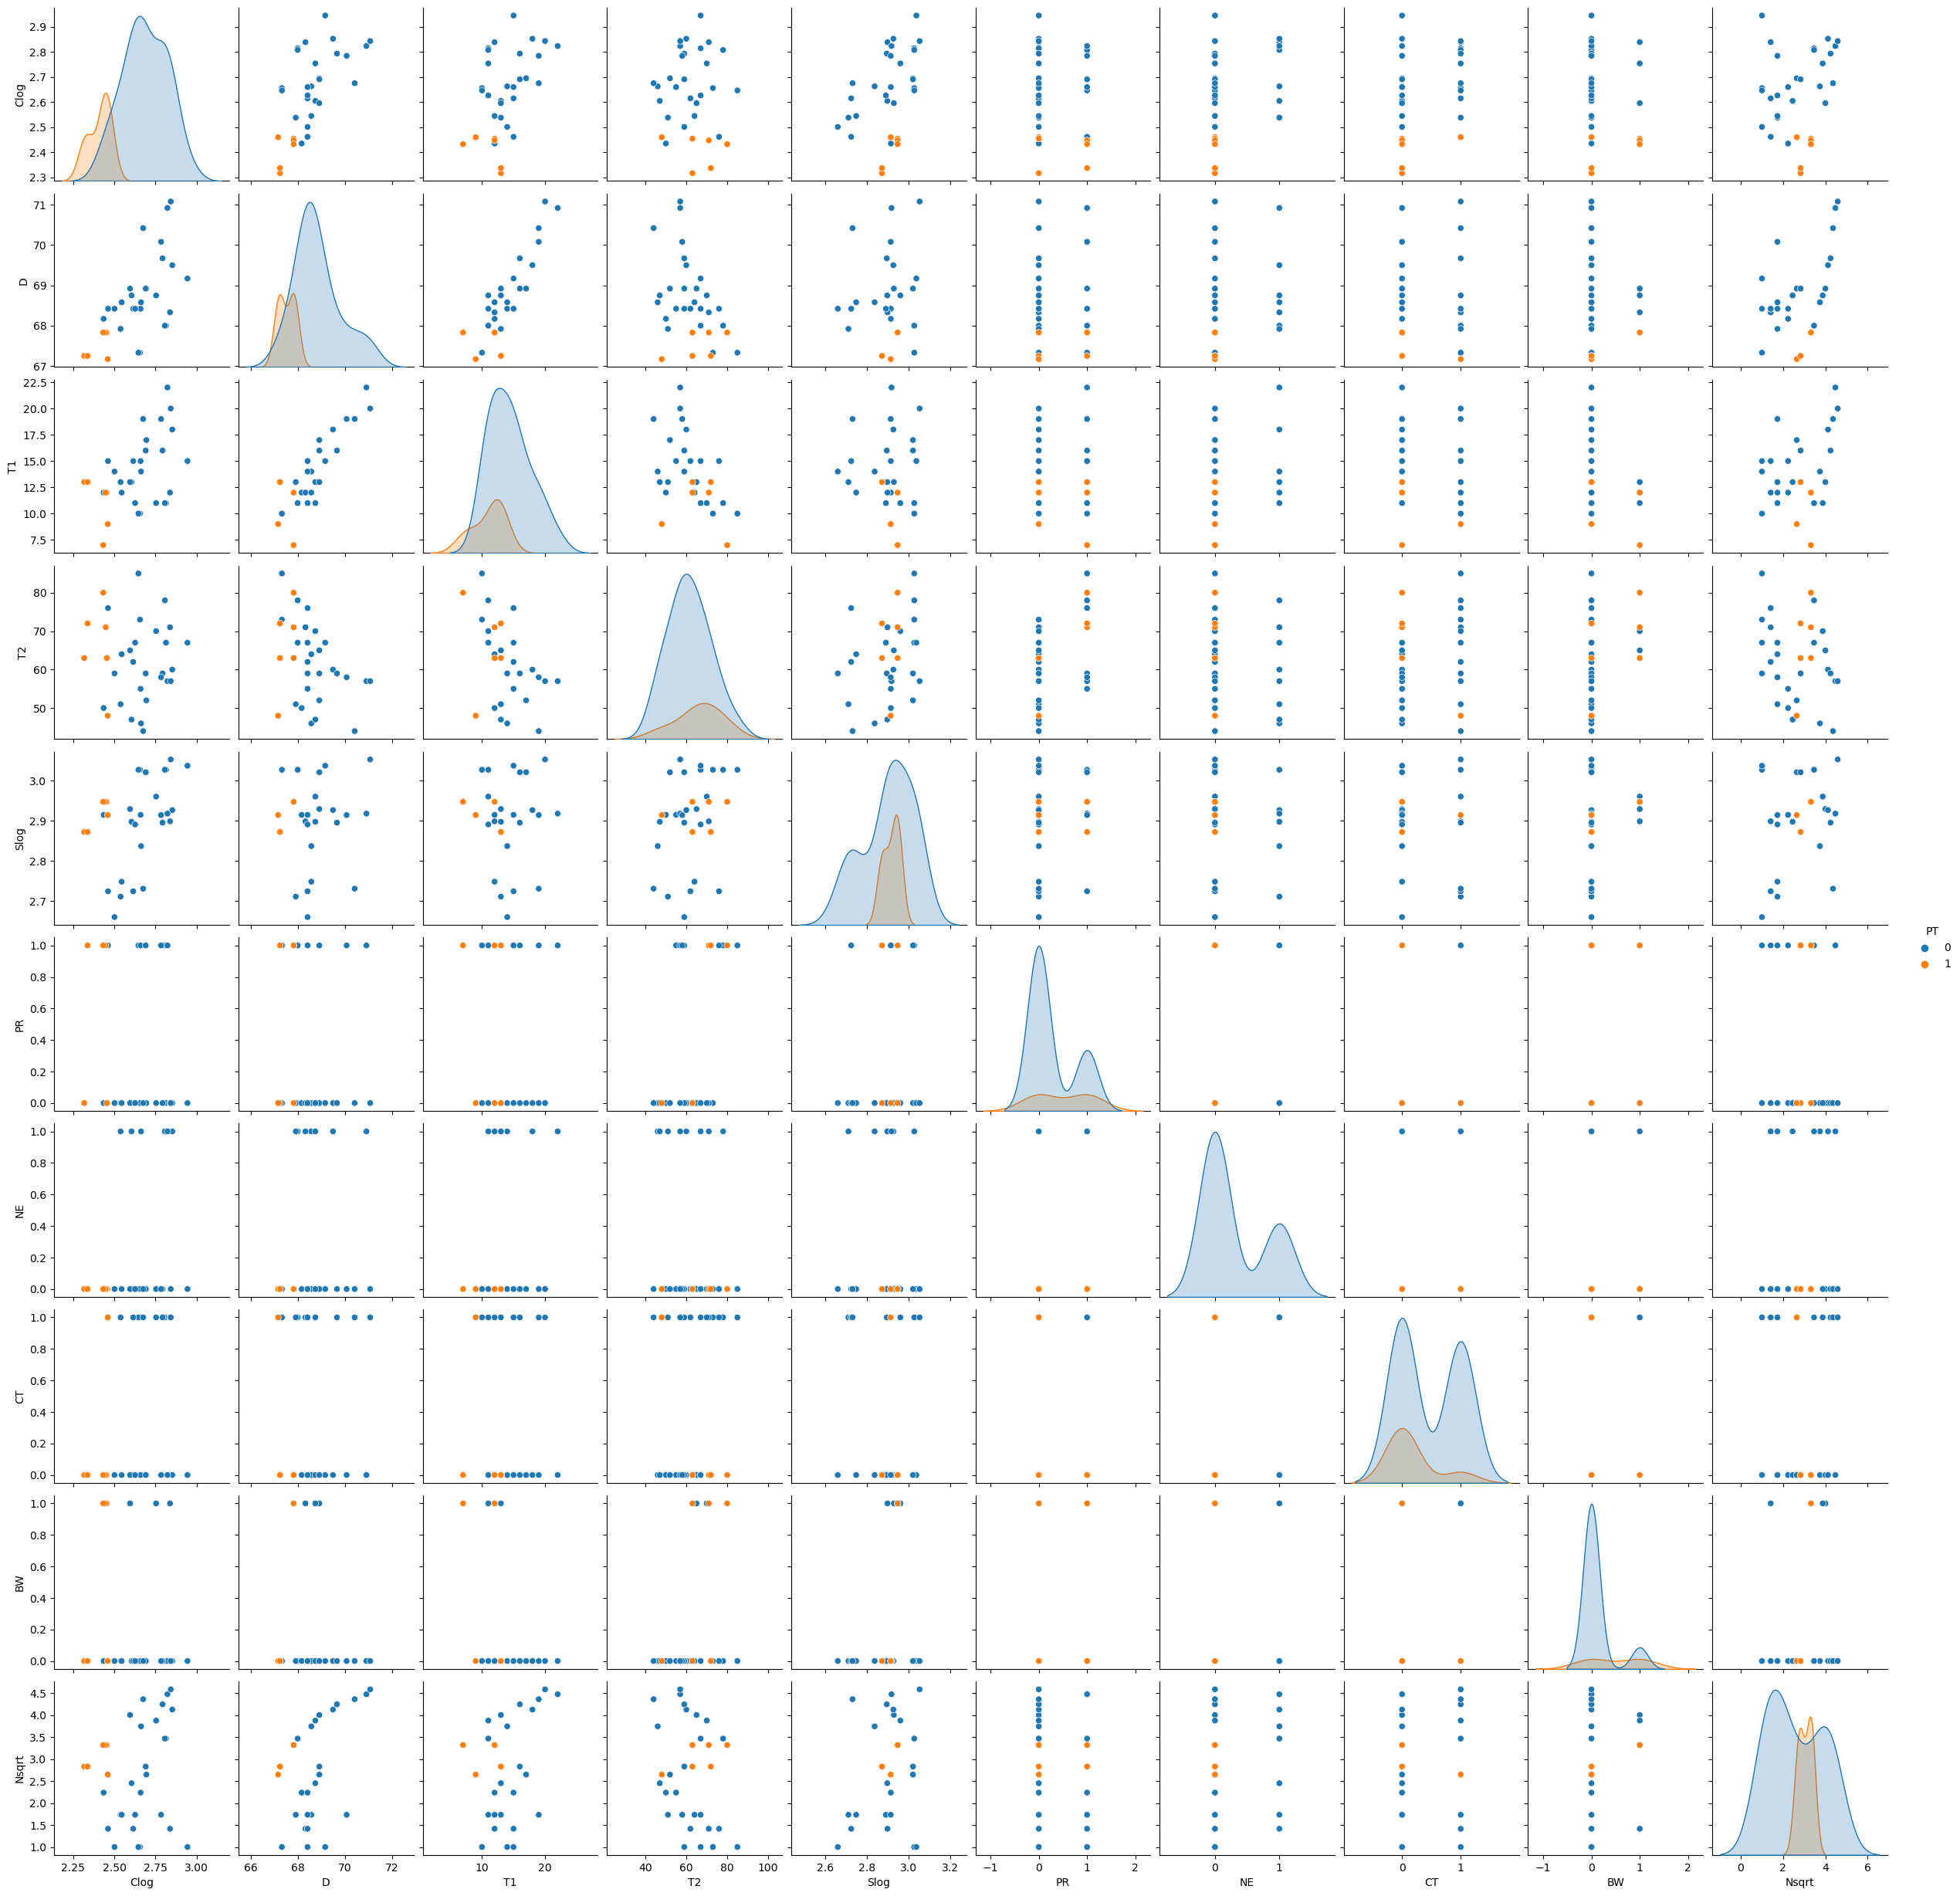

In [8]:
sns.pairplot(data, hue='PT')

Linear regression with full model

In [9]:
modfull = smf.ols(formula='Clog ~ D + T1 + T2 + Slog + PR + NE + CT + BW + Nsqrt + PT', data=data).fit()
modfull.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Clog   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     13.85
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           3.98e-07
Time:                        14:46:30   Log-Likelihood:                 45.372
No. Observations:                  32   AIC:                            -68.74
Df Residuals:                      21   BIC:                            -52.62
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0259      2.347     -2.567      0.018     -10.907      -1.144
D              0.0952      0.036      2.661      0.015       0.021       0.170
T1             0.0026      0.010      0.276      0.785      -0.017       0.022
T2             0.0023      0.002      1.155      0.261      -0.002       0.006
Slog           0.6925      0.137      5.050      0.000       0.407       0.978
PR            -0.0457      0.036     -1.284      0.213      -0.120       0.028
NE             0.1105      0.034      3.257      0.004       0.040       0.181
CT             0.0534      0.030      1.798      0.087      -0.008       0.115
BW             0.0128      0.045      0.282      0.781      -0.082       0.107
Nsqrt         -0.0300      0.018     -1.684      0.107      -0.067       0.007
PT            -0.0995      0.056     -1.789      0.088      -0.215       0.016
==============================================================================
Omnibus:                        0.947   Durbin-Watson:                   2.318
Prob(Omnibus):                  0.623   Jarque-Bera (JB):                0.831
Skew:                          -0.368   Prob(JB):                        0.660
Kurtosis:                       2.715   Cond. No.                     1.73e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Linear regression trivial model

In [10]:
modsmall = smf.ols(formula='Clog ~ 1', data=data).fit()
modsmall.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Clog   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 13 Feb 2023   Prob (F-statistic):                nan
Time:                        14:46:30   Log-Likelihood:                 12.927
No. Observations:                  32   AIC:                            -23.85
Df Residuals:                      31   BIC:                            -22.39
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6349      0.029     90.810      0.000       2.576       2.694
==============================================================================
Omnibus:                        1.935   Durbin-Watson:                   1.378
Prob(Omnibus):                  0.380   Jarque-Bera (JB):                1.184
Skew:                          -0.126   Prob(JB):                        0.553
Kurtosis:                       2.092   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2. Akaike information criterion

Choose a model by AIC in a stepwise algorithm (backward)

In [11]:
final_vars, iterations_logs = backwardSelection(X, y, model_type='linear', elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : T1
Eliminated : BW
Eliminated : PR
Regained :  PR
                            OLS Regression Results                            
Dep. Variable:                   Clog   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     18.85
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           2.19e-08
Time:                        14:46:30   Log-Likelihood:                 45.288
No. Observations:                  32   AIC:                            -72.58
Df Residuals:                      23   BIC:                            -59.38
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

In [12]:
print(iterations_logs)


                            OLS Regression Results                            
Dep. Variable:                   Clog   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     13.85
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           3.98e-07
Time:                        14:46:30   Log-Likelihood:                 45.372
No. Observations:                  32   AIC:                            -68.74
Df Residuals:                      21   BIC:                            -52.62
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -6.0259      2.347     -2.567      0.

In [13]:
final_vars

['intercept', 'D', 'T2', 'Slog', 'PR', 'NE', 'CT', 'Nsqrt', 'PT']

fit reduced model again

In [14]:
modbackward = smf.ols(formula='Clog ~ D + T2 + Slog + PR + NE + CT + Nsqrt + PT', data=data).fit()
modbackward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Clog   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     18.85
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           2.19e-08
Time:                        14:46:30   Log-Likelihood:                 45.288
No. Observations:                  32   AIC:                            -72.58
Df Residuals:                      23   BIC:                            -59.38
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.5221      1.522     -4.285      0.000      -9.671      -3.374
D              0.1032      0.021      4.901      0.000       0.060       0.147
T2             0.0024      0.002      1.433      0.165      -0.001       0.006
Slog           0.6856      0.130      5.282      0.000       0.417       0.954
PR            -0.0452      0.032     -1.433      0.165      -0.111       0.020
NE             0.1112      0.032      3.432      0.002       0.044       0.178
CT             0.0518      0.028      1.852      0.077      -0.006       0.110
Nsqrt         -0.0297      0.016     -1.804      0.084      -0.064       0.004
PT            -0.0939      0.051     -1.855      0.076      -0.199       0.011
==============================================================================
Omnibus:                        1.181   Durbin-Watson:                   2.273
Prob(Omnibus):                  0.554   Jarque-Bera (JB):                0.954
Skew:                          -0.408   Prob(JB):                        0.621
Kurtosis:                       2.781   Cond. No.                     1.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

diagnostic tools

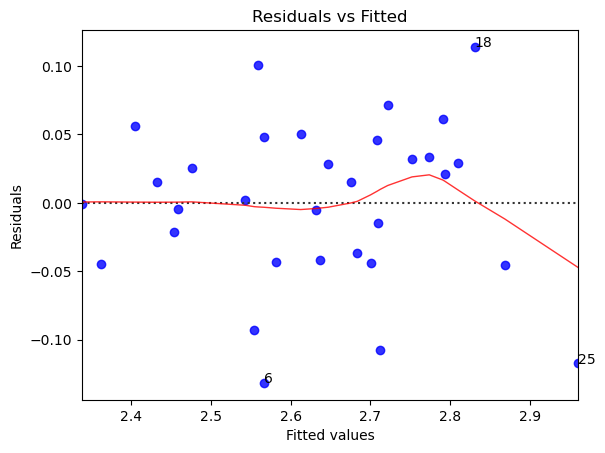

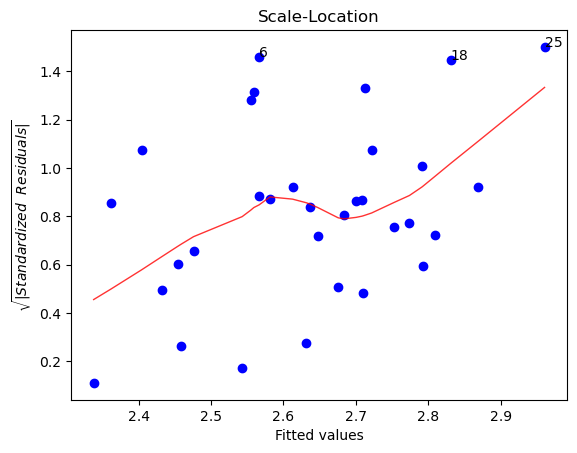

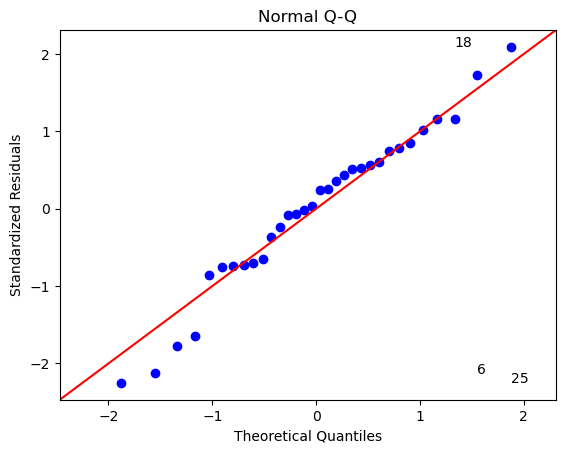

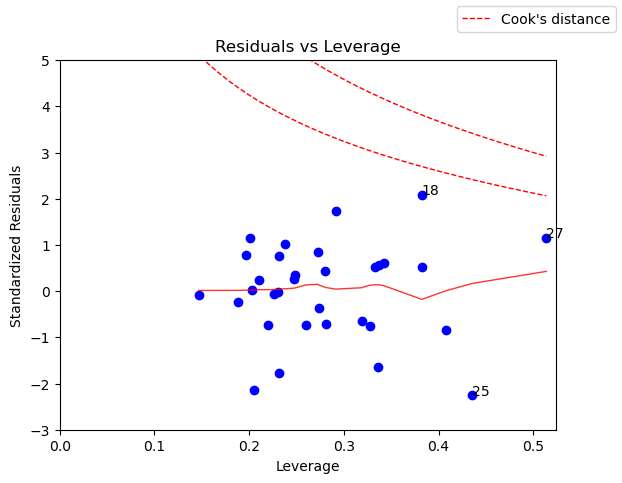

In [15]:
diagnostic_plots(X, y, model_fit=modbackward)

REMARKS: The scale-location plot shows a strong increase which is not extrem compared to the simulated curves.\
=> Check residuals versus individual explanatory variables.

Choose a model by AIC in a stepwise algorithm (forward)

In [16]:
final_vars, iterations_logs = forwardSelection(X, y, model_type='linear', elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
Entered : PT 	AIC : -41.250652068982845
Entered : Slog 	AIC : -54.487017226972824
Entered : D 	AIC : -63.4615235999384
Entered : NE 	AIC : -68.20404386127106
Break : Significance Level
                            OLS Regression Results                            
Dep. Variable:                   Clog   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     27.91
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           3.04e-09
Time:                        14:46:31   Log-Likelihood:                 39.102
No. Observations:                  32   AIC:                            -68.20
Df Residuals:                      27   BIC:                            -60.88
Df Model:                           4                                         
Covariance Type:            nonrobust

In [17]:
print(iterations_logs)


Entered : PT


                            OLS Regression Results                            
Dep. Variable:                   Clog   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     25.00
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           2.33e-05
Time:                        14:46:31   Log-Likelihood:                 22.625
No. Observations:                  32   AIC:                            -41.25
Df Residuals:                      30   BIC:                            -38.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.6873      0.024    

In [18]:
final_vars

['intercept', 'PT', 'Slog', 'D', 'NE']

fit reduced model again

In [19]:
modforward = smf.ols(formula='Clog ~ PT + Slog + D + NE', data=data).fit()
modforward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Clog   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     27.91
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           3.04e-09
Time:                        14:46:31   Log-Likelihood:                 39.102
No. Observations:                  32   AIC:                            -68.20
Df Residuals:                      27   BIC:                            -60.88
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4612      1.146     -3.021      0.005      -5.812      -1.110
PT            -0.1844      0.042     -4.347      0.000      -0.271      -0.097
Slog           0.6629      0.129      5.120      0.000       0.397       0.928
D              0.0610      0.016      3.821      0.001       0.028       0.094
NE             0.0831      0.033      2.516      0.018       0.015       0.151
==============================================================================
Omnibus:                        2.387   Durbin-Watson:                   2.513
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                1.222
Skew:                          -0.179   Prob(JB):                        0.543
Kurtosis:                       3.888   Cond. No.                     5.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

diagnostic tools

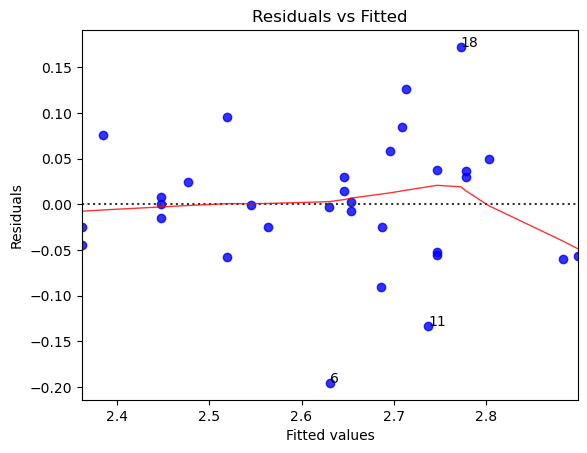

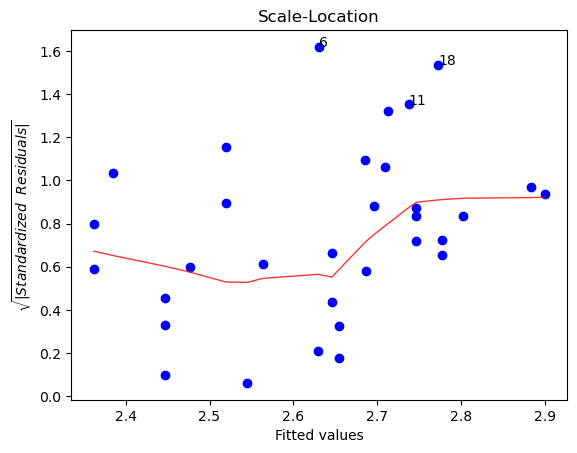

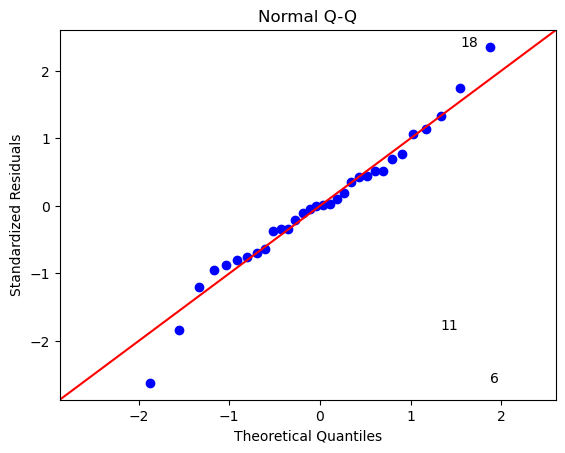

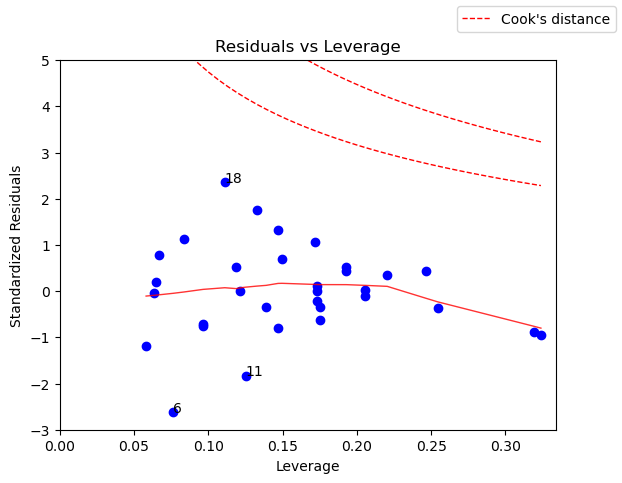

In [20]:
diagnostic_plots(X, y, model_fit=modforward)

REMARK: Good model.